# 🔮 P(bid) prediction


----
-----


---
----

In [10]:
import factor_utils as factor_utils # custom libary
from importlib import reload # reload 
reload(factor_utils)

<module 'factor_utils' from 'c:\\python\\spain_comp\\factor_utils.py'>

In [11]:
import seaborn as sns
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [12]:
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [13]:
data = pd.read_csv("C:\\python\\spain_comp\\train_data.csv")
data_test = pd.read_csv("C:\\python\\spain_comp\\test_data.csv")

In [14]:
data_test.columns

Index(['target', 'flr', 'sellerClearPrice', 'hour', 'ssp', 'dsp',
       'auctionBidFloorSource', 'sdk', 'sdkver', 'bundle', 'os', 'lang',
       'country', 'region', 'request_context_device_w',
       'request_context_device_h', 'bidderFlrPolicy', 'adt', 'dc', 'contype',
       'request_context_device_type', 'ifa', 'price'],
      dtype='object')

In [15]:
data.describe(include = "all")

,target,flr,sellerClearPrice,hour,ssp,dsp,auctionBidFloorSource,sdk,sdkver,bundle,os,lang,country,region,request_context_device_w,request_context_device_h,bidderFlrPolicy,adt,dc,contype,request_context_device_type,ifa,price
count,9640735.00,9640735.00,9640735.00,9640735.00,9640735.00,9640735.00,9640735,9640733,9640733,9640735,9640734,9640734,9640734,9292023,9640734.00,9640734.00,9640734,9640734,9640734,9640734.00,9640734.00,5279641,9640734.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,1,14,5,2,1303,121,565,NaN,NaN,3,1,1,NaN,NaN,990006,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,ml,BidMachine,2.4.0.2,gAAAAABmcEFTEPcMMU786QLAISLs22JucTR9XWAoRq7NAM...,ios,en,US,tx,NaN,NaN,original,interstitial,US,NaN,NaN,31b780ad-8418-4252-af67-3683b8b6ceda,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,4335419,9640733,5277994,5585485,5596411,5879832,4995857,468045,NaN,NaN,5703725,9640734,9640734,NaN,NaN,328,NaN
mean,0.08,2.97,3.31,11.56,157.00,81.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,693.22,1365.05,NaN,NaN,NaN,2.48,4.21,NaN,4.42
std,0.28,4.07,4.43,7.68,0.00,24.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.04,591.37,NaN,NaN,NaN,1.18,0.41,NaN,5.96
min,0.00,0.01,0.01,0.00,157.00,23.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.00,2.00,NaN,NaN,NaN,0.00,1.00,NaN,0.01
25%,0.00,0.69,0.83,4.00,157.00,76.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,393.00,852.00,NaN,NaN,NaN,2.00,4.00,NaN,1.13
50%,0.00,1.49,1.78,12.00,157.00,80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.00,1080.00,NaN,NaN,NaN,2.00,4.00,NaN,2.42
75%,0.00,4.65,4.41,19.00,157.00,80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900.00,1800.00,NaN,NaN,NaN,2.00,4.00,NaN,5.80


take only first several thousand rows

In [ ]:
data = data.sample(n=500000) 

In [16]:
#data = data.head(500000)

# 🔍 Exploratory Data Analysis

> **OVERALL GOAL:** 
> - Get an understanding for which variables are important, view summary statistics, and visualize the data

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   target                       500000 non-null  int64  
 1   flr                          500000 non-null  float64
 2   sellerClearPrice             500000 non-null  float64
 3   hour                         500000 non-null  int64  
 4   ssp                          500000 non-null  int64  
 5   dsp                          500000 non-null  int64  
 6   auctionBidFloorSource        500000 non-null  object 
 7   sdk                          499999 non-null  object 
 8   sdkver                       499999 non-null  object 
 9   bundle                       500000 non-null  object 
 10  os                           500000 non-null  object 
 11  lang                         500000 non-null  object 
 12  country                      500000 non-null  object 
 13 

In [18]:
numeric_features = ['flr', 'sellerClearPrice', 'request_context_device_w', 'request_context_device_h', 'price']
time_feature = 'hour'
categoric_features = ['ssp', 'dsp', 'auctionBidFloorSource', 'sdk', 'sdkver', 'bundle', 'os', 'lang', 
                      'country', 'region', 'bidderFlrPolicy', 'adt', 'dc', 'contype', 'request_context_device_type', 'ifa']
target_feature = 'target'
print(len(numeric_features)  + len(time_feature) + len(categoric_features) )

25


In [19]:
for name in data.columns:
    if (name not in categoric_features):        
        if (name not in numeric_features):           
            if (name  not in time_feature):
                    print("missing feature:" + name)

missing feature:target


## 🎯 ✔️ `Target`

In [20]:
target_mean = data.target.mean()
print(target_mean)

0.028348


## ✔️ One factor analysis  ( `numeric_features`)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.009999998
max = 444.72287
after cutting: min =0.010599993
after cutting: max =7.0
Start plotting...
 min x for ROC 0.010599993 max x for ROC 7.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


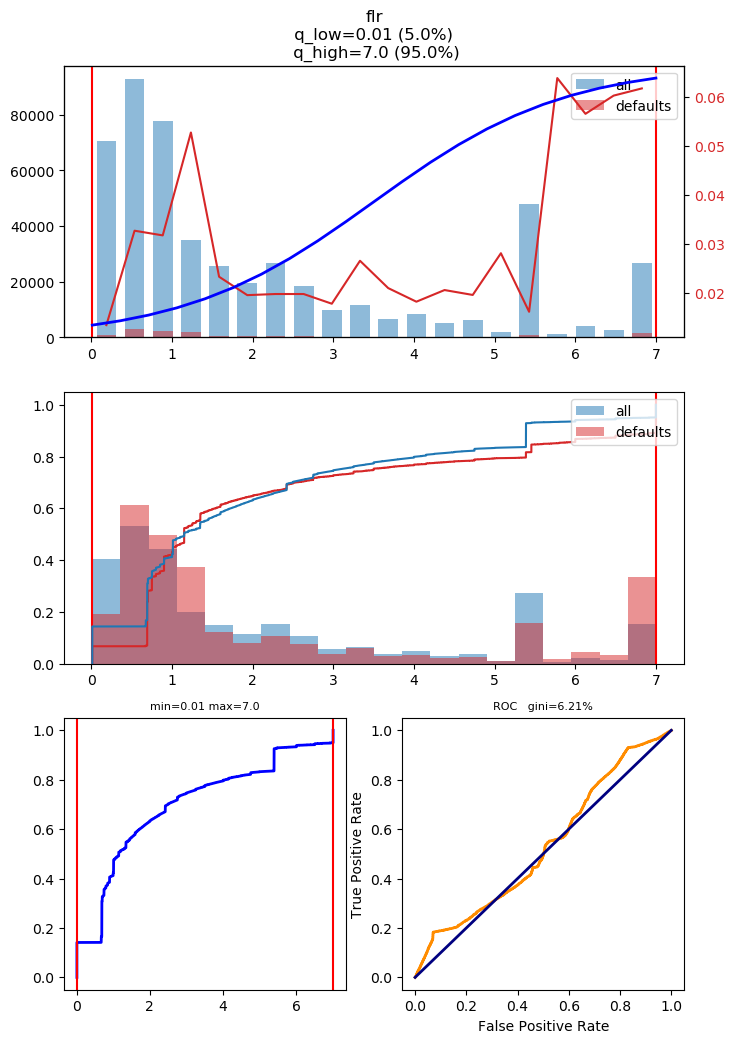

In [21]:
f_name = "flr"
factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,            
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.010132998
max = 371.45
after cutting: min =0.500577
after cutting: max =7.873867399999998
Start plotting...
 min x for ROC 0.500577 max x for ROC 7.873867399999998
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


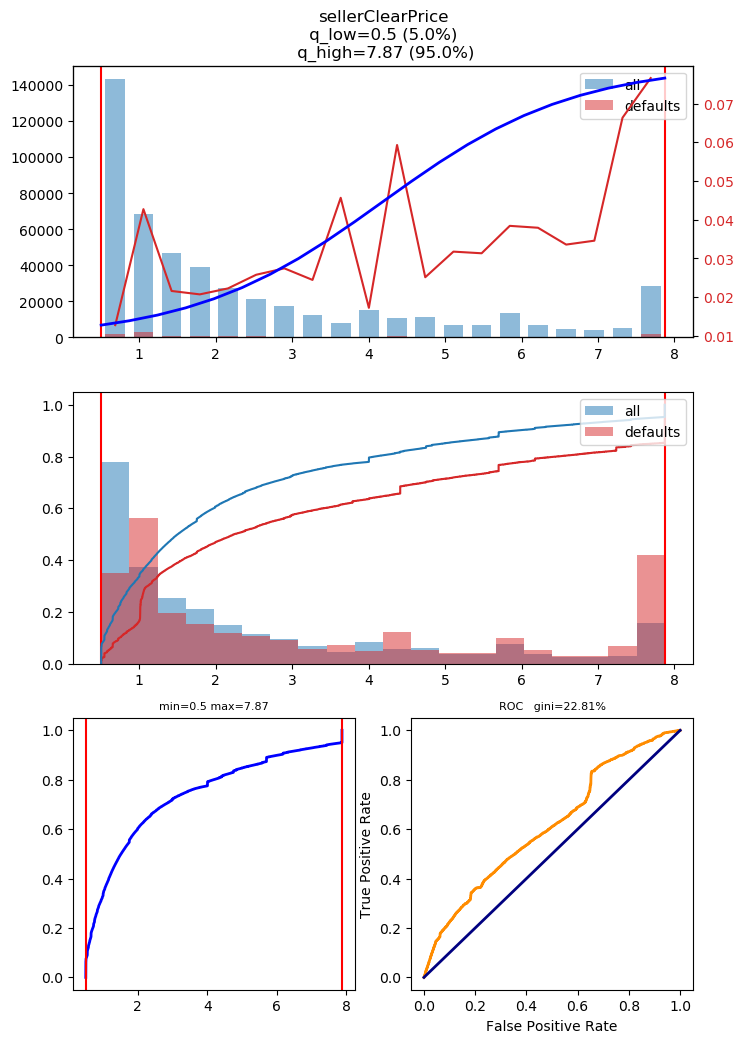

In [22]:
f_name = "sellerClearPrice"
factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,            
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 320.0
max = 2960.0
after cutting: min =375.0
after cutting: max =1080.0
Start plotting...
 min x for ROC 375.0 max x for ROC 1080.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


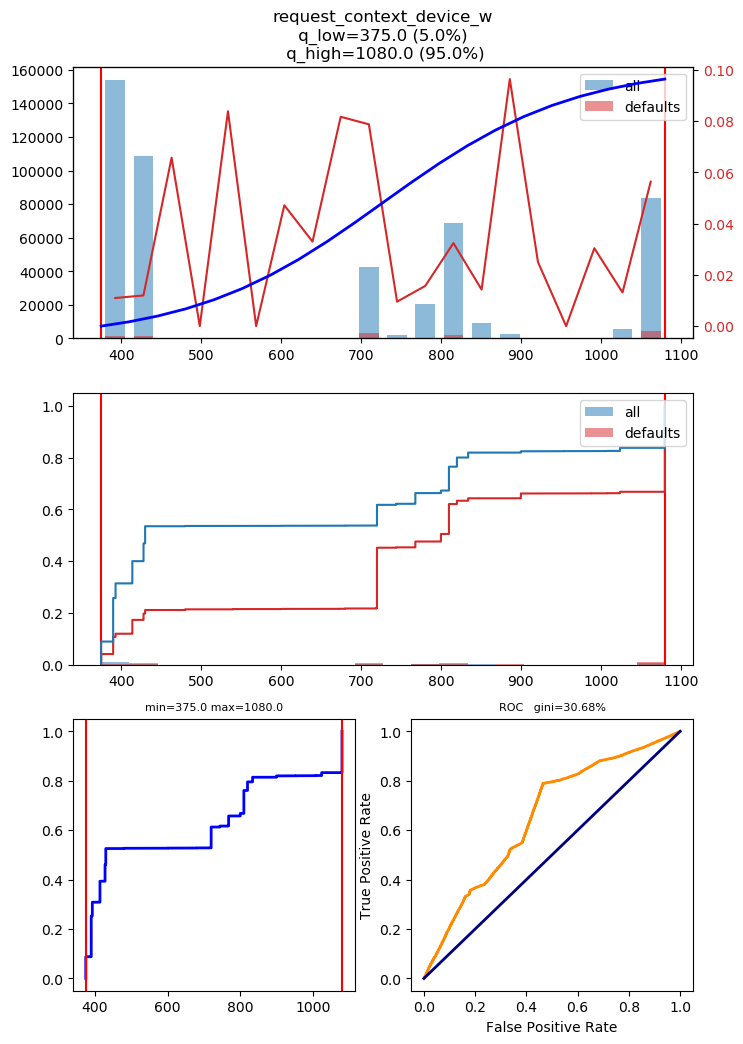

In [23]:
f_name = 'request_context_device_w'
factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,            
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 320.0
max = 3216.0
after cutting: min =812.0
after cutting: max =2400.0
Start plotting...
 min x for ROC 812.0 max x for ROC 2400.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


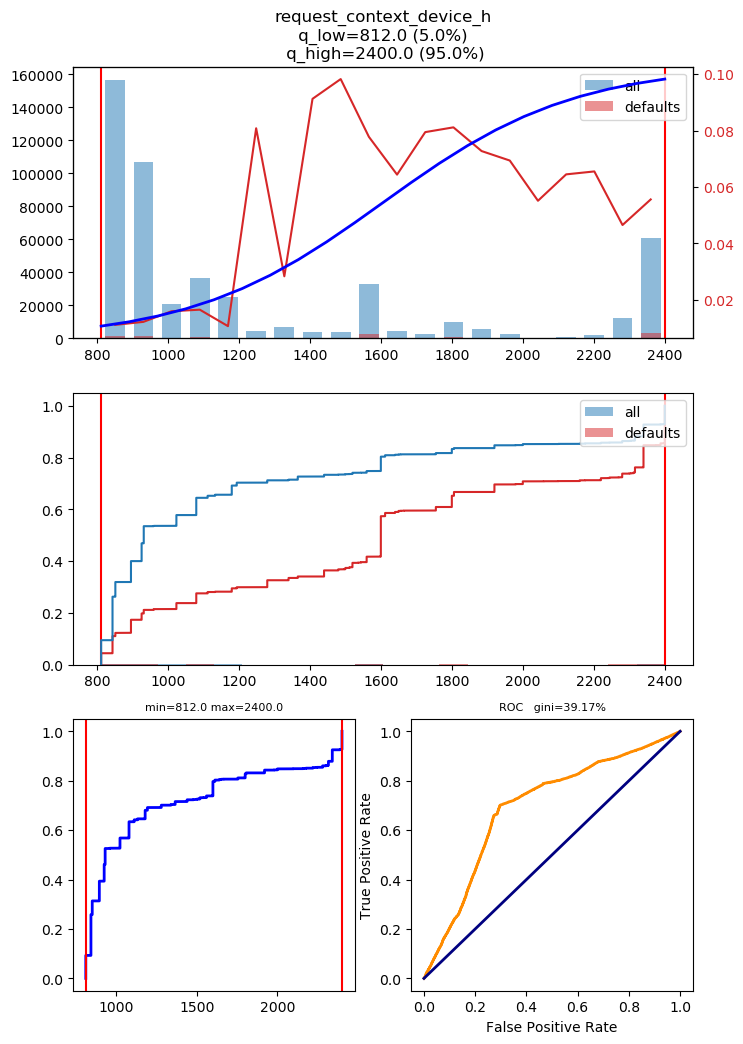

In [24]:
f_name = 'request_context_device_h'
factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,            
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.010666795
max = 500.0
after cutting: min =0.6914997
after cutting: max =10.581081649999994
Start plotting...
 min x for ROC 0.6914997 max x for ROC 10.581081649999994
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


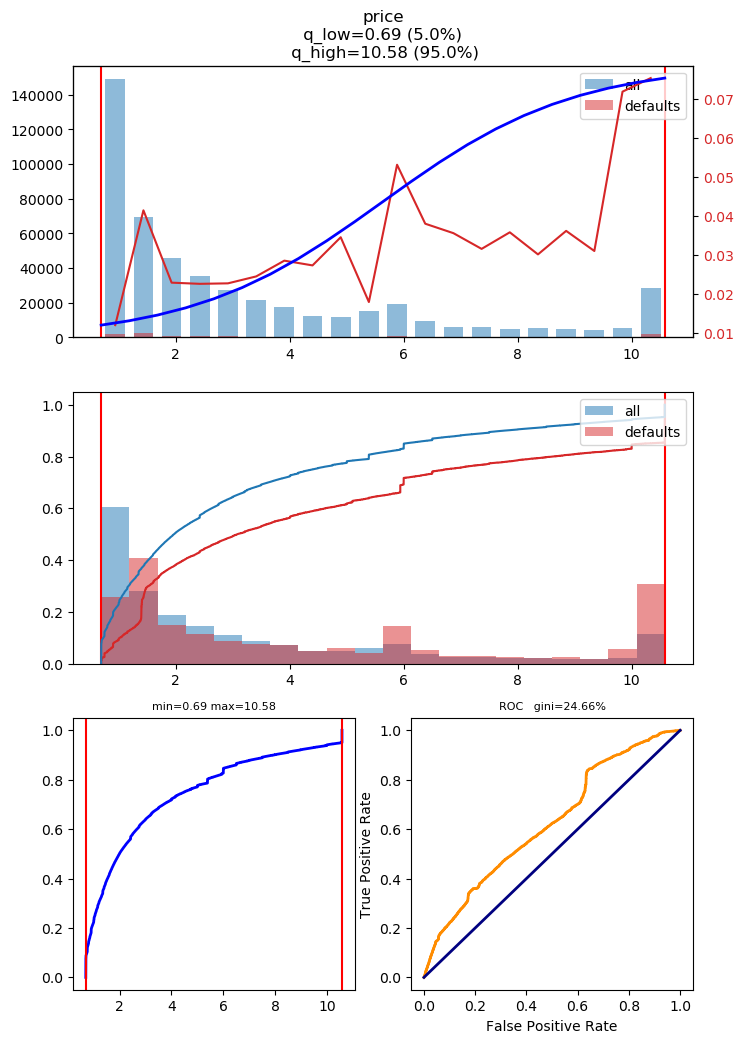

In [25]:
f_name =  'price'
factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,            
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

#make new time features

In [26]:
time_feature = 'hour'
# Преобразование в синус и косинус
data['hour_sin'] = np.sin(2 * np.pi * data[time_feature] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data[time_feature] / 24)

#test
data_test['hour_sin'] = np.sin(2 * np.pi * data_test[time_feature] / 24)
data_test['hour_cos'] = np.cos(2 * np.pi * data_test[time_feature] / 24)

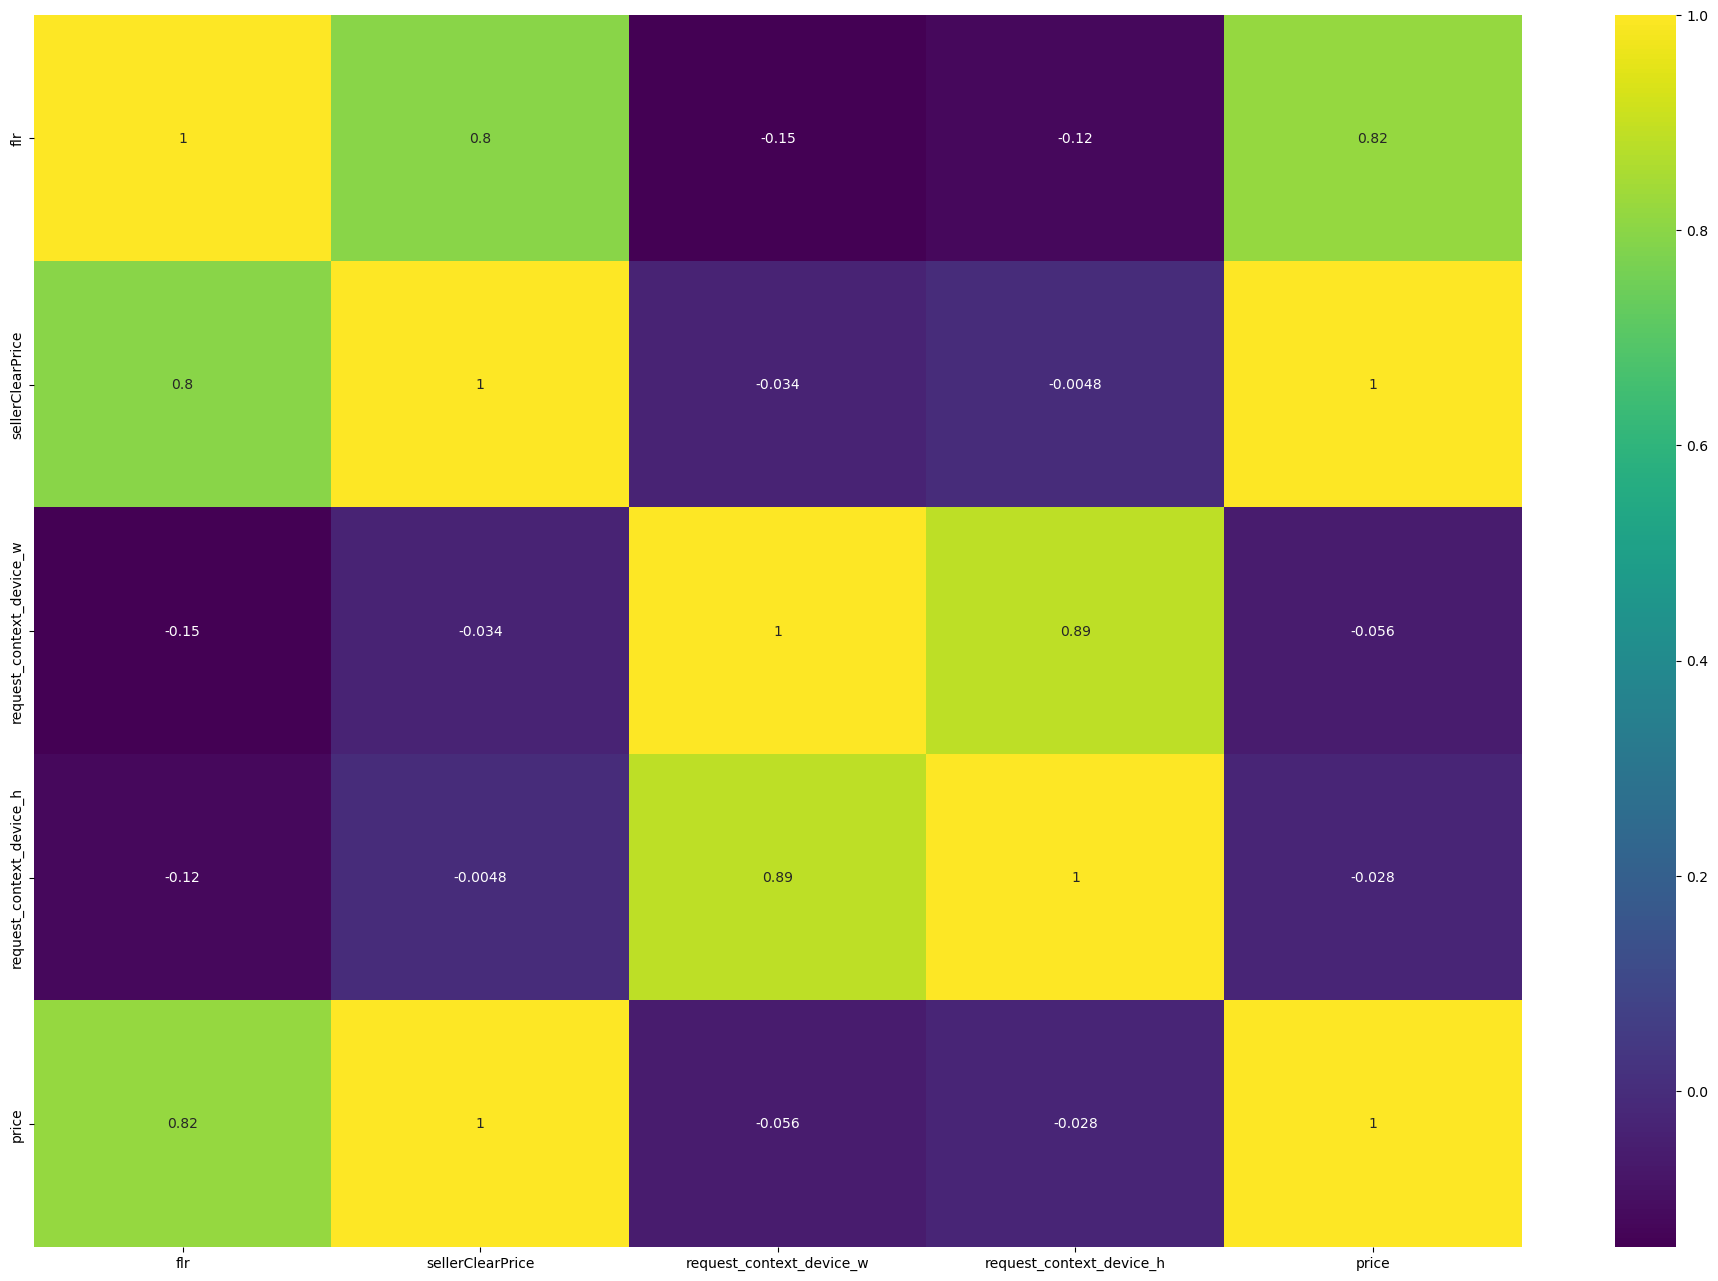

In [27]:
plt.figure(figsize=(24, 16))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='viridis')

### Result -> from numeric features we can choose 5 features  (they are not correlated):


#### Adding new features to dataset (logistic transformation is applied)

In [28]:
for fName in numeric_features: 
    x = data[fName]
    p_low = 0.05
    p_high = 0.95
    low_quant = x.quantile(p_low) 
    high_quant = x.quantile(p_high)
    logistic_factor = factor_utils.logistic_transformation(x, low_quant, high_quant)['values']
    data.drop(columns = fName, inplace = True)
    newName = fName + "_logistic"
    data[newName] = logistic_factor

#test
    x = data_test[fName]
    logistic_factor = factor_utils.logistic_transformation(x, low_quant, high_quant)['values']
    data_test.drop(columns = fName, inplace=True)
    newName = fName + "_logistic"
    data_test[newName] = logistic_factor

In [29]:
numeric_features_selected = ['flr_logistic', 'sellerClearPrice_logistic', 'request_context_device_w_logistic', 'request_context_device_h_logistic', 'price_logistic']                           

In [30]:
data.columns

Index(['target', 'hour', 'ssp', 'dsp', 'auctionBidFloorSource', 'sdk',
       'sdkver', 'bundle', 'os', 'lang', 'country', 'region',
       'bidderFlrPolicy', 'adt', 'dc', 'contype',
       'request_context_device_type', 'ifa', 'hour_sin', 'hour_cos',
       'flr_logistic', 'sellerClearPrice_logistic',
       'request_context_device_w_logistic',
       'request_context_device_h_logistic', 'price_logistic'],
      dtype='object')

## ✔️ One factor analysis 

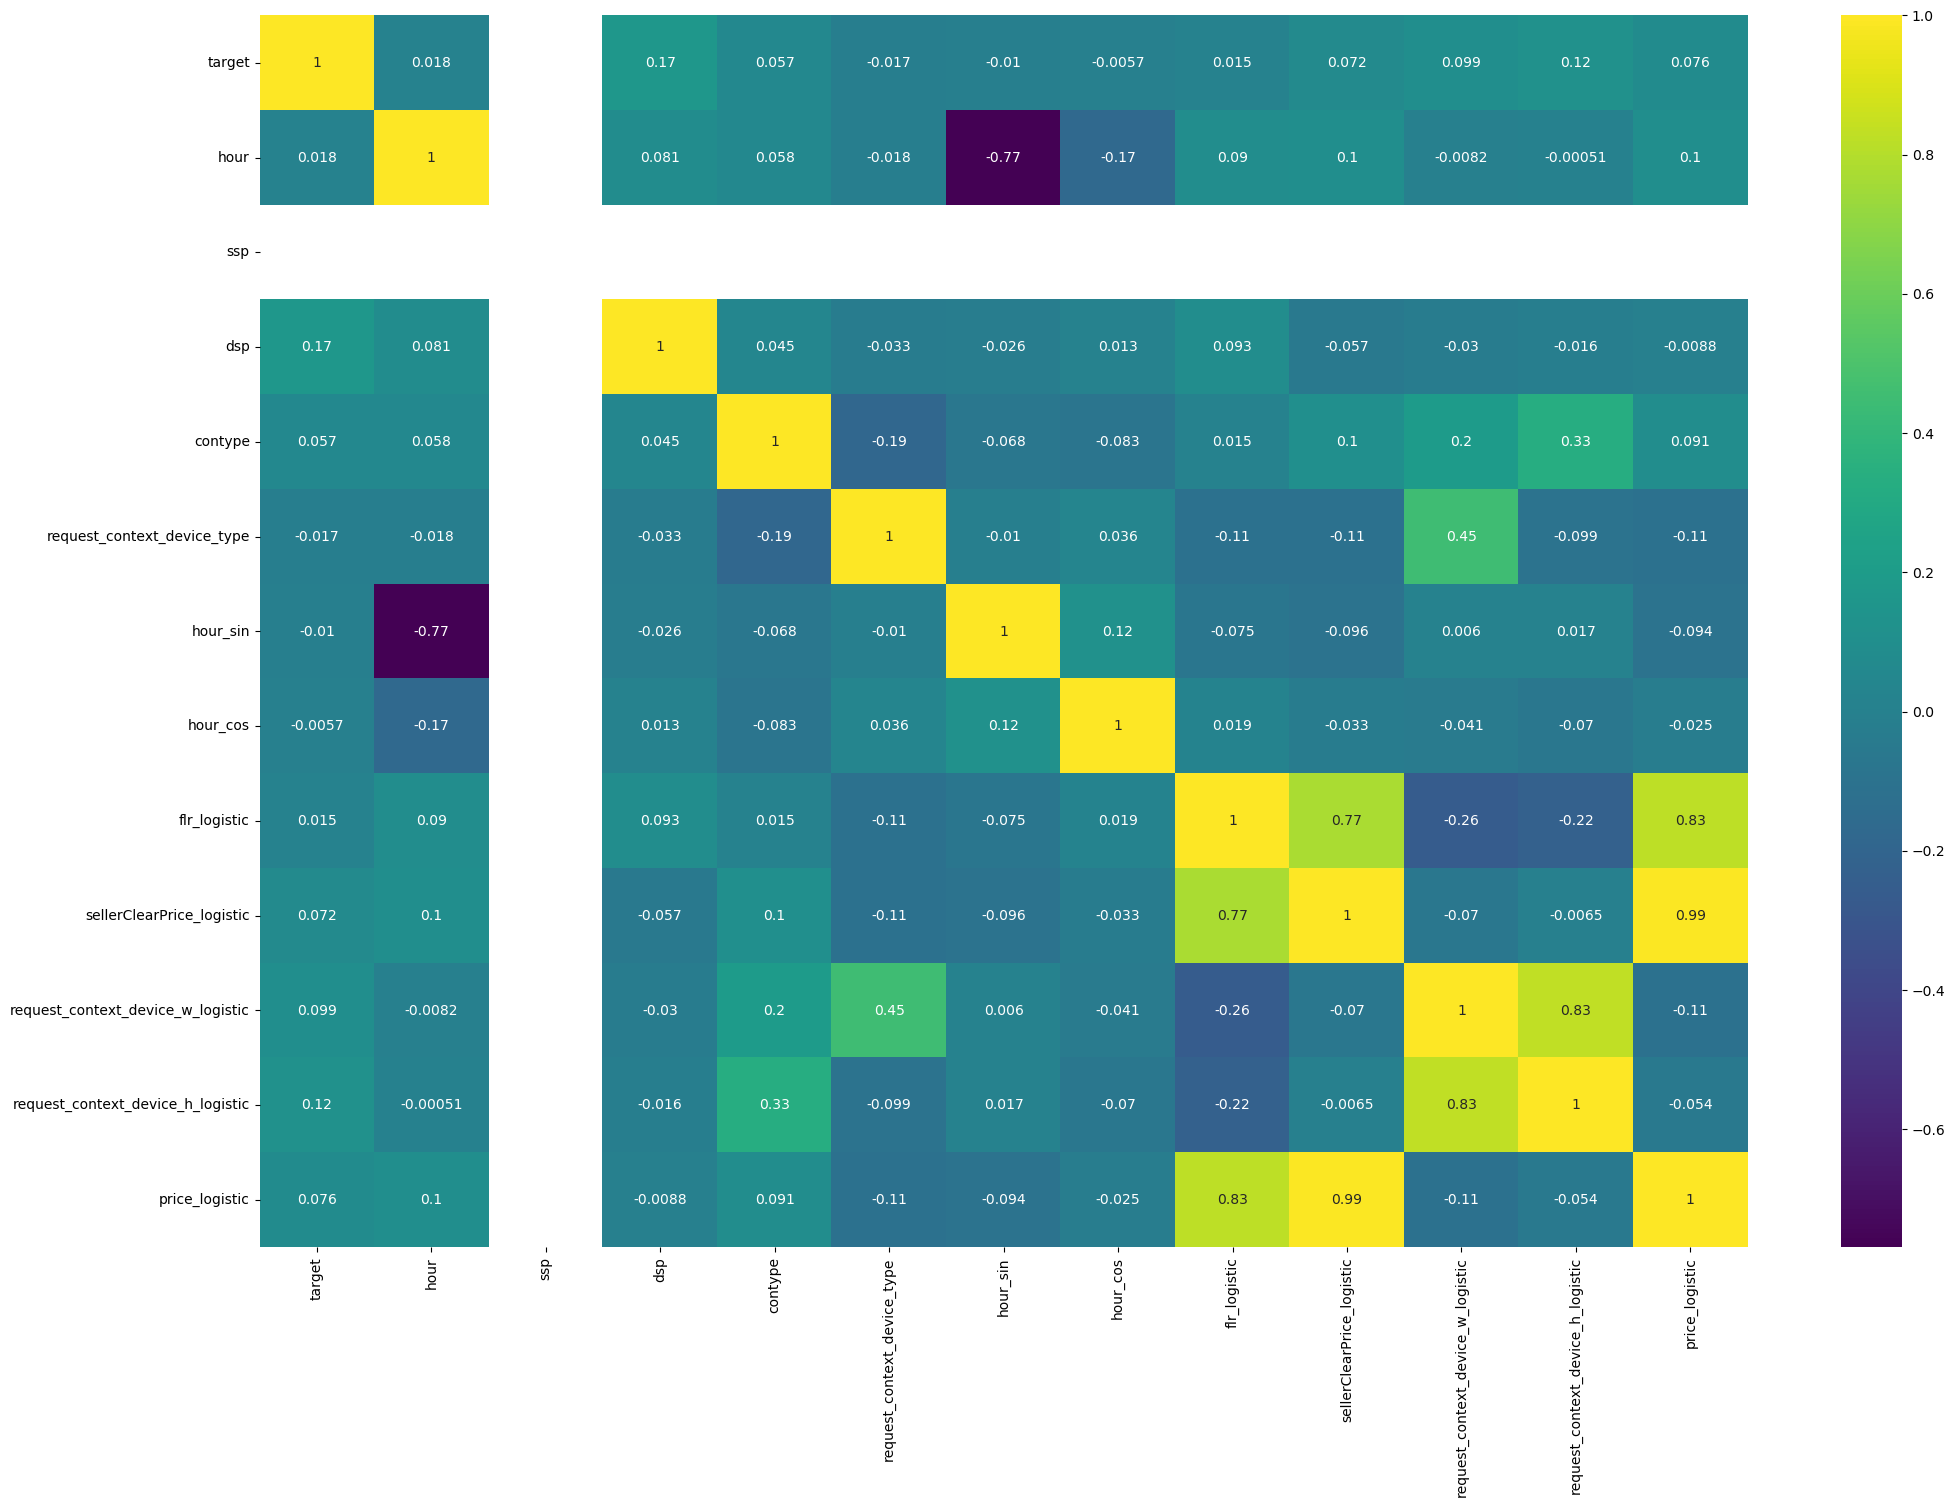

In [31]:
plt.figure(figsize=(24, 16))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

## ✔️ One factor analysis  ( `categorical_features`)

In [32]:
categoric_features

['ssp',
 'dsp',
 'auctionBidFloorSource',
 'sdk',
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 'adt',
 'dc',
 'contype',
 'request_context_device_type',
 'ifa']

In [33]:
factor_name = 'dsp'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

c:\Users\user\.conda\envs\yuku\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [34]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
0,80,358719,353912,4807,0.73,0.34,0.76,0.30,0.01,0.72,358719,0.72
1,41,80236,79270,966,0.16,0.07,0.87,0.08,0.00,0.16,438955,0.88
2,122,24678,21596,3082,0.04,0.22,-1.59,0.27,0.01,0.05,463633,0.93
3,104,8898,8358,540,0.02,0.04,-0.80,0.02,0.00,0.02,472531,0.95
7,227,5647,5444,203,0.01,0.01,-0.25,0.00,0.00,0.01,478178,0.96
8,46,4471,4371,100,0.01,0.01,0.24,0.00,0.00,0.01,482649,0.97
5,76,4199,2513,1686,0.01,0.12,-3.14,0.36,0.00,0.01,486848,0.97
6,180,4138,2102,2036,0.00,0.14,-3.50,0.49,0.00,0.01,490986,0.98
10,132,3466,3457,9,0.01,0.00,2.42,0.02,0.00,0.01,494452,0.99
9,149,2635,2082,553,0.00,0.04,-2.21,0.08,0.00,0.01,497087,0.99


take only first 10 values as it is.. others code as 250

In [35]:
values_to_keep = [80, 76, 41, 122, 87, 104, 227, 46, 132, 180]
map_dict = {item: item for item in values_to_keep}
default_value  = 250
data['dsp_grouped'] = data['dsp'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['dsp_grouped'] = data_test['dsp'].apply(lambda x: map_dict.get(x, default_value))

In [36]:
factor_name = 'dsp_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [37]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
0,80,358719,353912,4807,0.73,0.34,0.76,0.30,0.01,0.72,358719,0.72
1,41,80236,79270,966,0.16,0.07,0.87,0.08,0.00,0.16,438955,0.88
2,122,24678,21596,3082,0.04,0.22,-1.59,0.27,0.01,0.05,463633,0.93
3,104,8898,8358,540,0.02,0.04,-0.80,0.02,0.00,0.02,472531,0.95
7,227,5647,5444,203,0.01,0.01,-0.25,0.00,0.00,0.01,478178,0.96
4,250,5209,4472,737,0.01,0.05,-1.73,0.07,0.00,0.01,483387,0.97
8,46,4471,4371,100,0.01,0.01,0.24,0.00,0.00,0.01,487858,0.98
5,76,4199,2513,1686,0.01,0.12,-3.14,0.36,0.00,0.01,492057,0.98
6,180,4138,2102,2036,0.00,0.14,-3.50,0.49,0.00,0.01,496195,0.99
9,132,3466,3457,9,0.01,0.00,2.42,0.02,0.00,0.01,499661,1.00


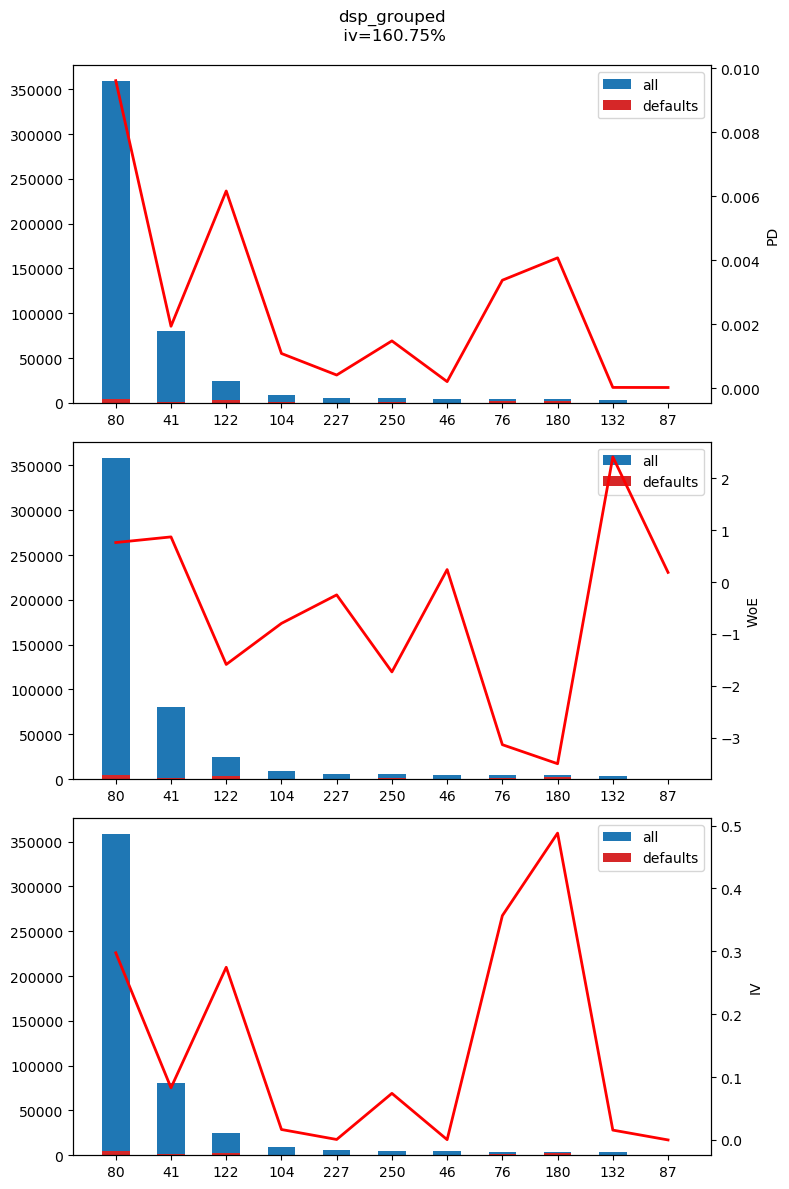

In [38]:
factor_utils.plot_iv(df, iv, factor_name)

In [39]:
factor_name = 'sdkver'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [40]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
0,2.4.0.2,328851,324835,4016,0.67,0.28,0.86,0.33,0.01,0.66,328851,0.66
1,2.5.0,133905,124848,9057,0.26,0.64,-0.91,0.35,0.02,0.27,462756,0.93
2,2.4.0.0,11395,11290,105,0.02,0.01,1.14,0.02,0.00,0.02,474151,0.95
3,2.2.0,8213,7881,332,0.02,0.02,-0.37,0.00,0.00,0.02,482364,0.96
4,2.3.3,5862,5455,407,0.01,0.03,-0.94,0.02,0.00,0.01,488226,0.98
6,2.1.0.0,4335,4285,50,0.01,0.00,0.92,0.00,0.00,0.01,492561,0.99
8,2.3.0.2,1573,1559,14,0.00,0.00,1.18,0.00,0.00,0.00,494134,0.99
10,1.9.5.0,1442,1433,9,0.00,0.00,1.54,0.00,0.00,0.00,495576,0.99
7,2.0.0.6,1274,1251,23,0.00,0.00,0.46,0.00,0.00,0.00,496850,0.99
11,1.9.4.1,983,974,9,0.00,0.00,1.15,0.00,0.00,0.00,497833,1.00


In [41]:
values_to_keep = ["	2.4.0.2","2.5.0" , "2.4.0.0","2.2.0", "2.3.3", "2.1.0.0" ]
map_dict = {item: item for item in values_to_keep}
default_value  = "others"
data['sdkver_grouped'] = data['sdkver'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['sdkver_grouped'] = data_test['sdkver'].apply(lambda x: map_dict.get(x, default_value))

## make WOE coding for <dsp_grouped>

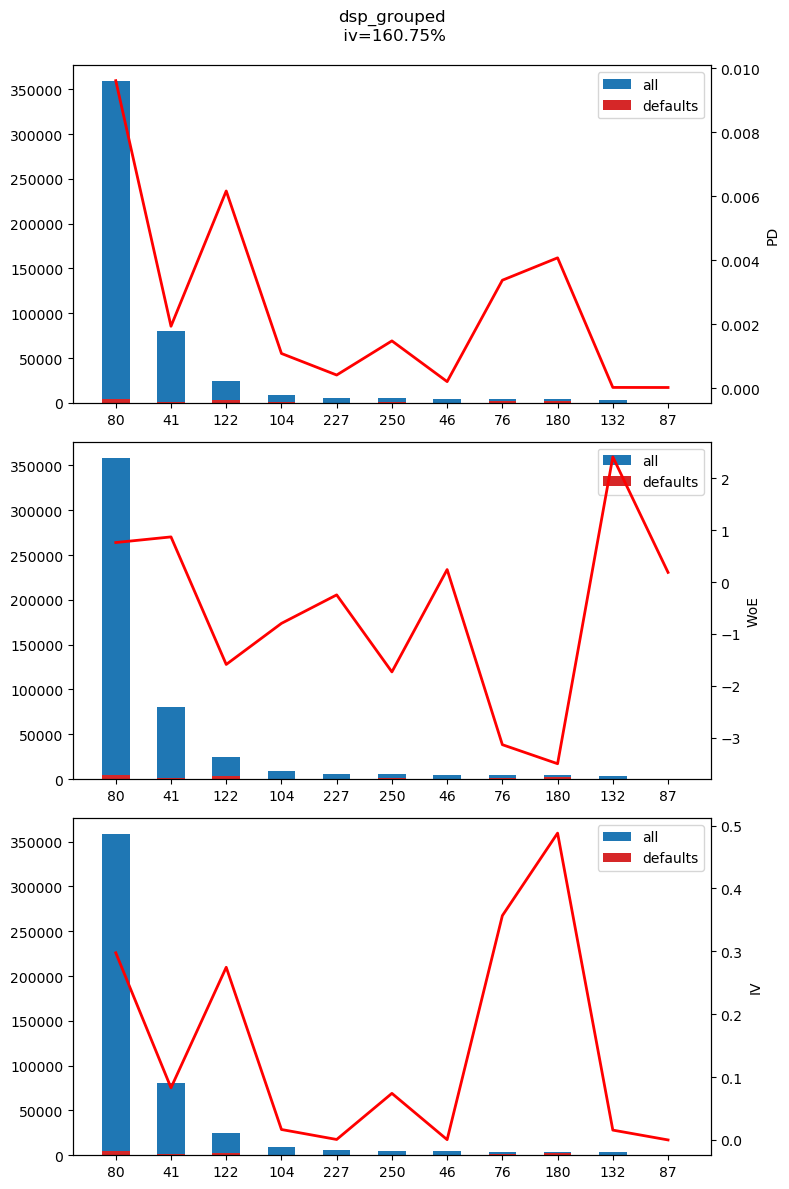

In [42]:
factor_name = 'dsp_grouped'   
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

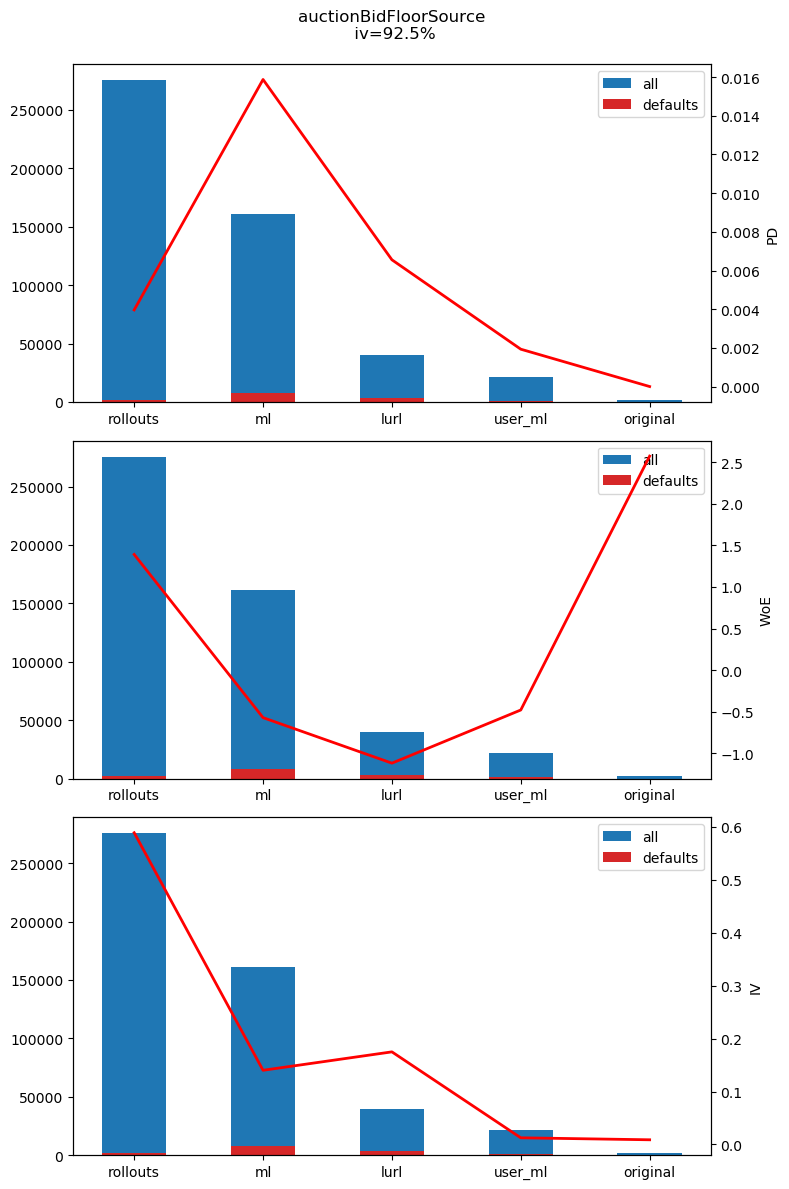

In [43]:
factor_name = 'auctionBidFloorSource'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

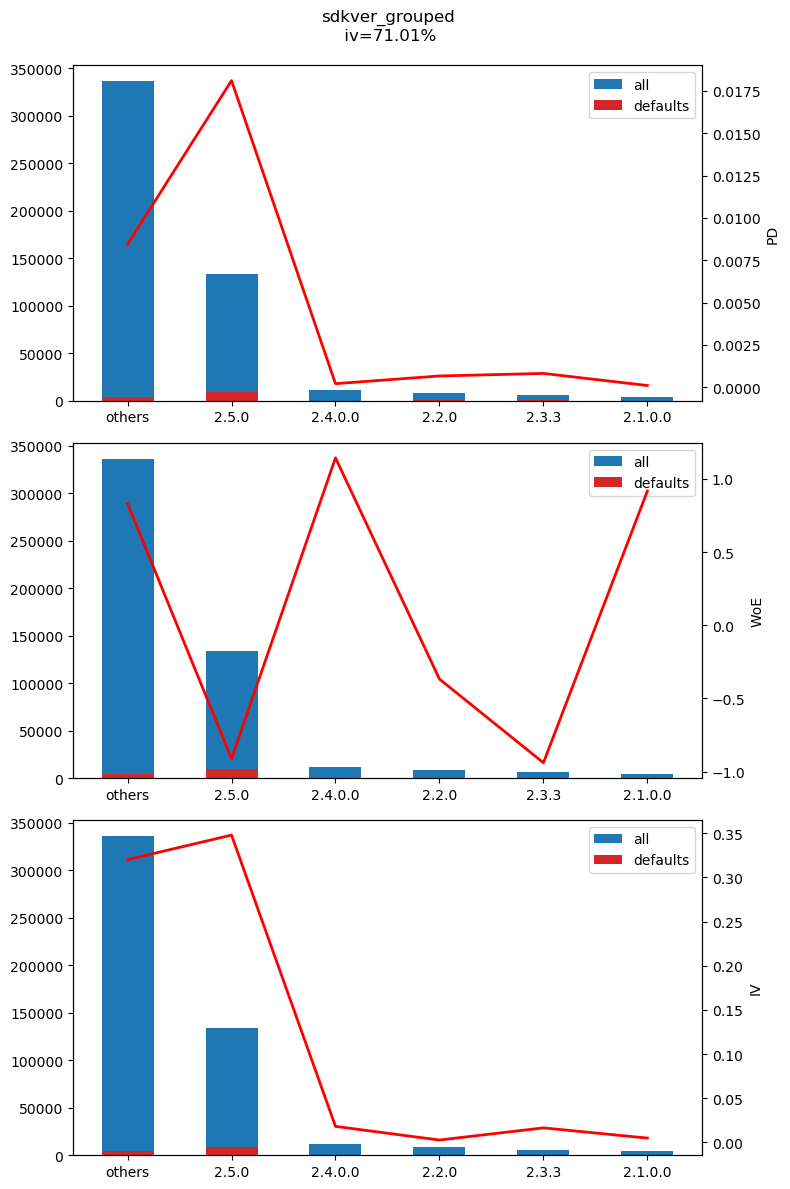

In [44]:
factor_name = 'sdkver_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

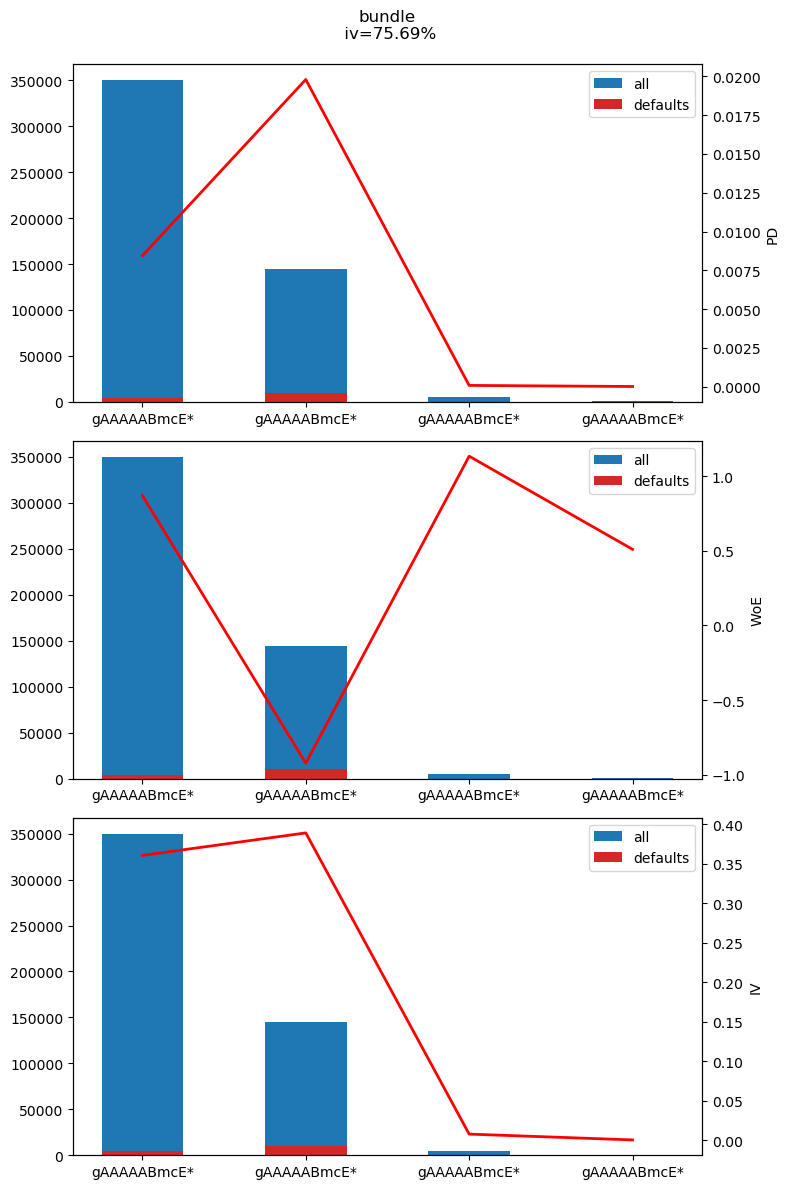

In [45]:
factor_name = 'bundle'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

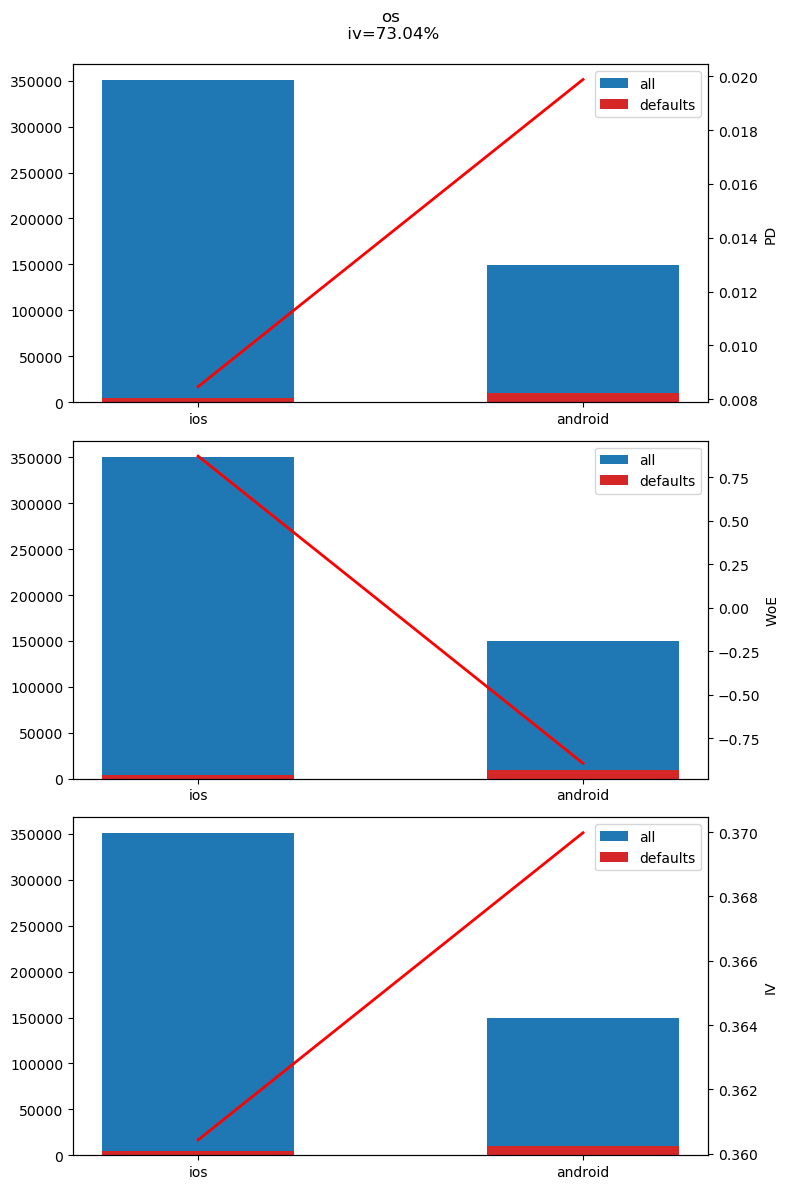

In [46]:
factor_name = 'os'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

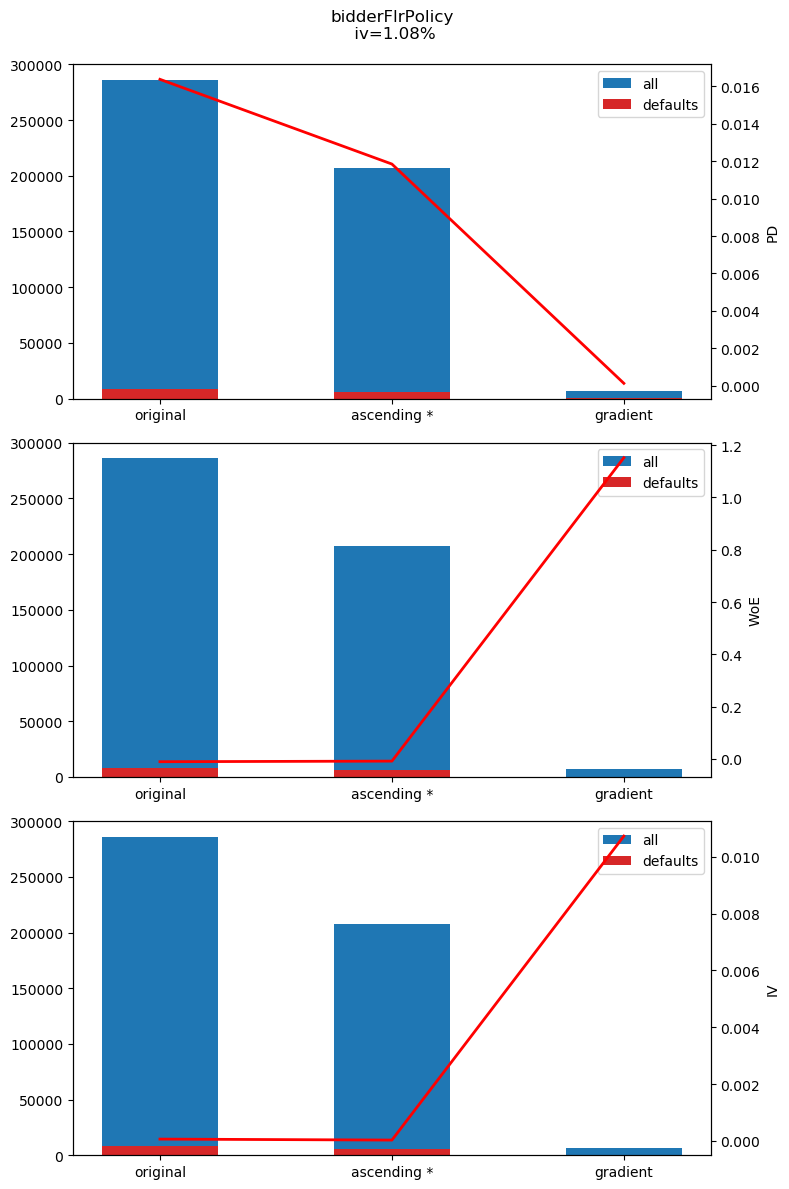

In [47]:
factor_name = 'bidderFlrPolicy'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

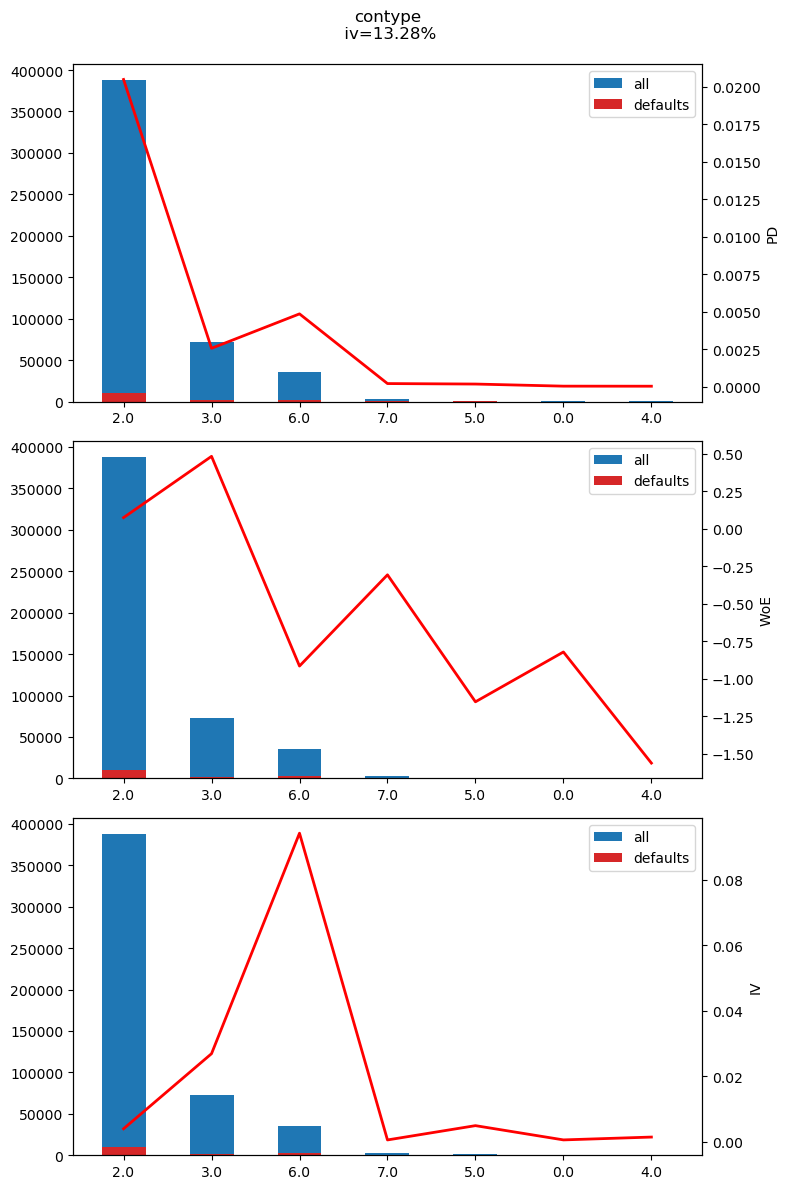

In [48]:
factor_name = 'contype'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

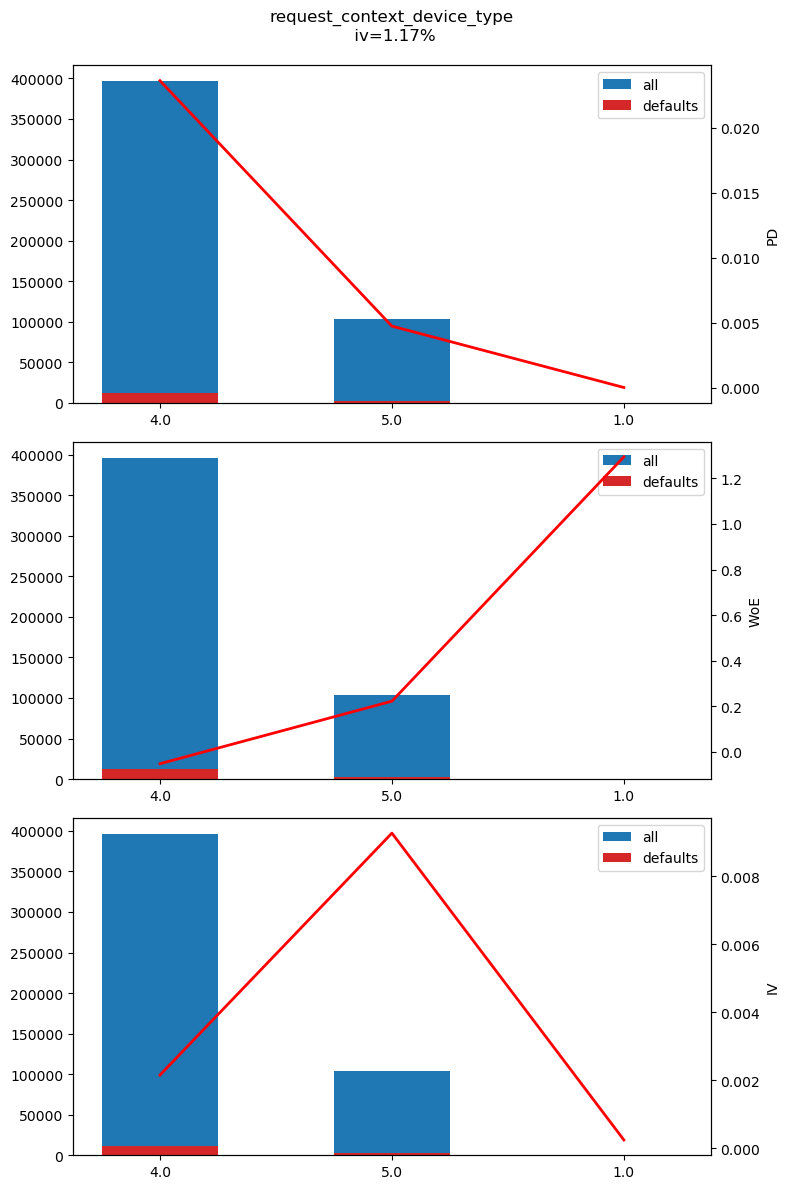

In [49]:
factor_name = 'request_context_device_type'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

In [50]:
to_delete_features = ['ssp','sdk','adt', 'dc',  'ifa']
 
numeric_logistic_features = ['flr_logistic', 'sellerClearPrice_logistic', 'request_context_device_w_logistic', 'request_context_device_h_logistic', 'price_logistic']
time_cos_sin_features = ['hour_cos', 'hour_sin']
categoric_woe_features = [ 'dsp_grouped_woe', 'auctionBidFloorSource_woe',  'sdkver_grouped_woe', 'bundle_woe', 'os_woe',  'bidderFlrPolicy_woe','contype_woe', 'request_context_device_type_woe']
not_yet_done_features = ['lang', 'country', 'region']
features_selected = numeric_logistic_features + time_cos_sin_features + categoric_woe_features 

In [51]:
lst = []

IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in categoric_woe_features:
    df, iv = factor_utils.calculate_woe_iv(data, col, target_feature)
               
    lst.append(df)
    IV_df = IV_df.append({
                "Variable" :col ,
                "IV" : iv,
                },ignore_index=True)

In [52]:
IV_df

,Variable,IV
0,dsp_grouped_woe,1.61
1,auctionBidFloorSource_woe,0.93
2,sdkver_grouped_woe,0.71
3,bundle_woe,0.76
4,os_woe,0.73
5,bidderFlrPolicy_woe,0.01
6,contype_woe,0.13
7,request_context_device_type_woe,0.01


### We can choose 3 variables ->

In [53]:
categoric_features_selected = categoric_woe_features

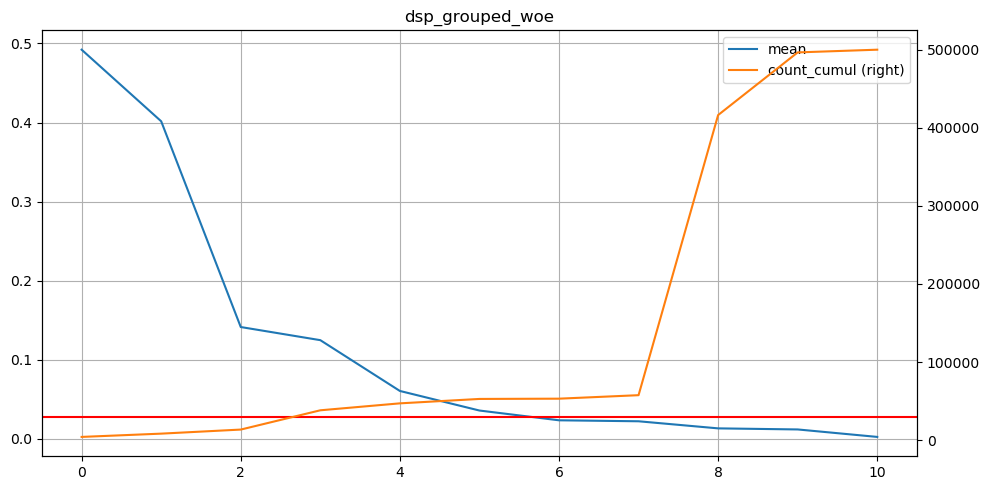

In [54]:
df1 = factor_utils.categorical_plot(data, 'dsp_grouped_woe', target_feature)

### making new variables -> making bins by uniting some categories 

### WOE encoding for categorical features

In [55]:
for feature_name in categoric_features_selected:
   data[feature_name] = data[feature_name].astype("object")

#test
   data_test[feature_name] = data_test[feature_name].astype("object")
    

In [56]:
features_selected = numeric_features_selected +  categoric_features_selected
features_selected


['flr_logistic',
 'sellerClearPrice_logistic',
 'request_context_device_w_logistic',
 'request_context_device_h_logistic',
 'price_logistic',
 'dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',
 'bidderFlrPolicy_woe',
 'contype_woe',
 'request_context_device_type_woe']

### refine dataset (deleting nonchosen features)

In [57]:
all_columns = features_selected + [target_feature]
all_columns
data = data[all_columns]

#test
data_test = data_test[all_columns]

## 📈 How  features correlate with the target variable?

In [58]:

data.corr()[target_feature].drop(target_feature).sort_values().hvplot.barh(
    width=600, height=400, 
    title="Correlation between Target and Numeric Features", 
    ylabel='Correlation', xlabel='Numerical Features', 
)

:Bars   [index]   (target)

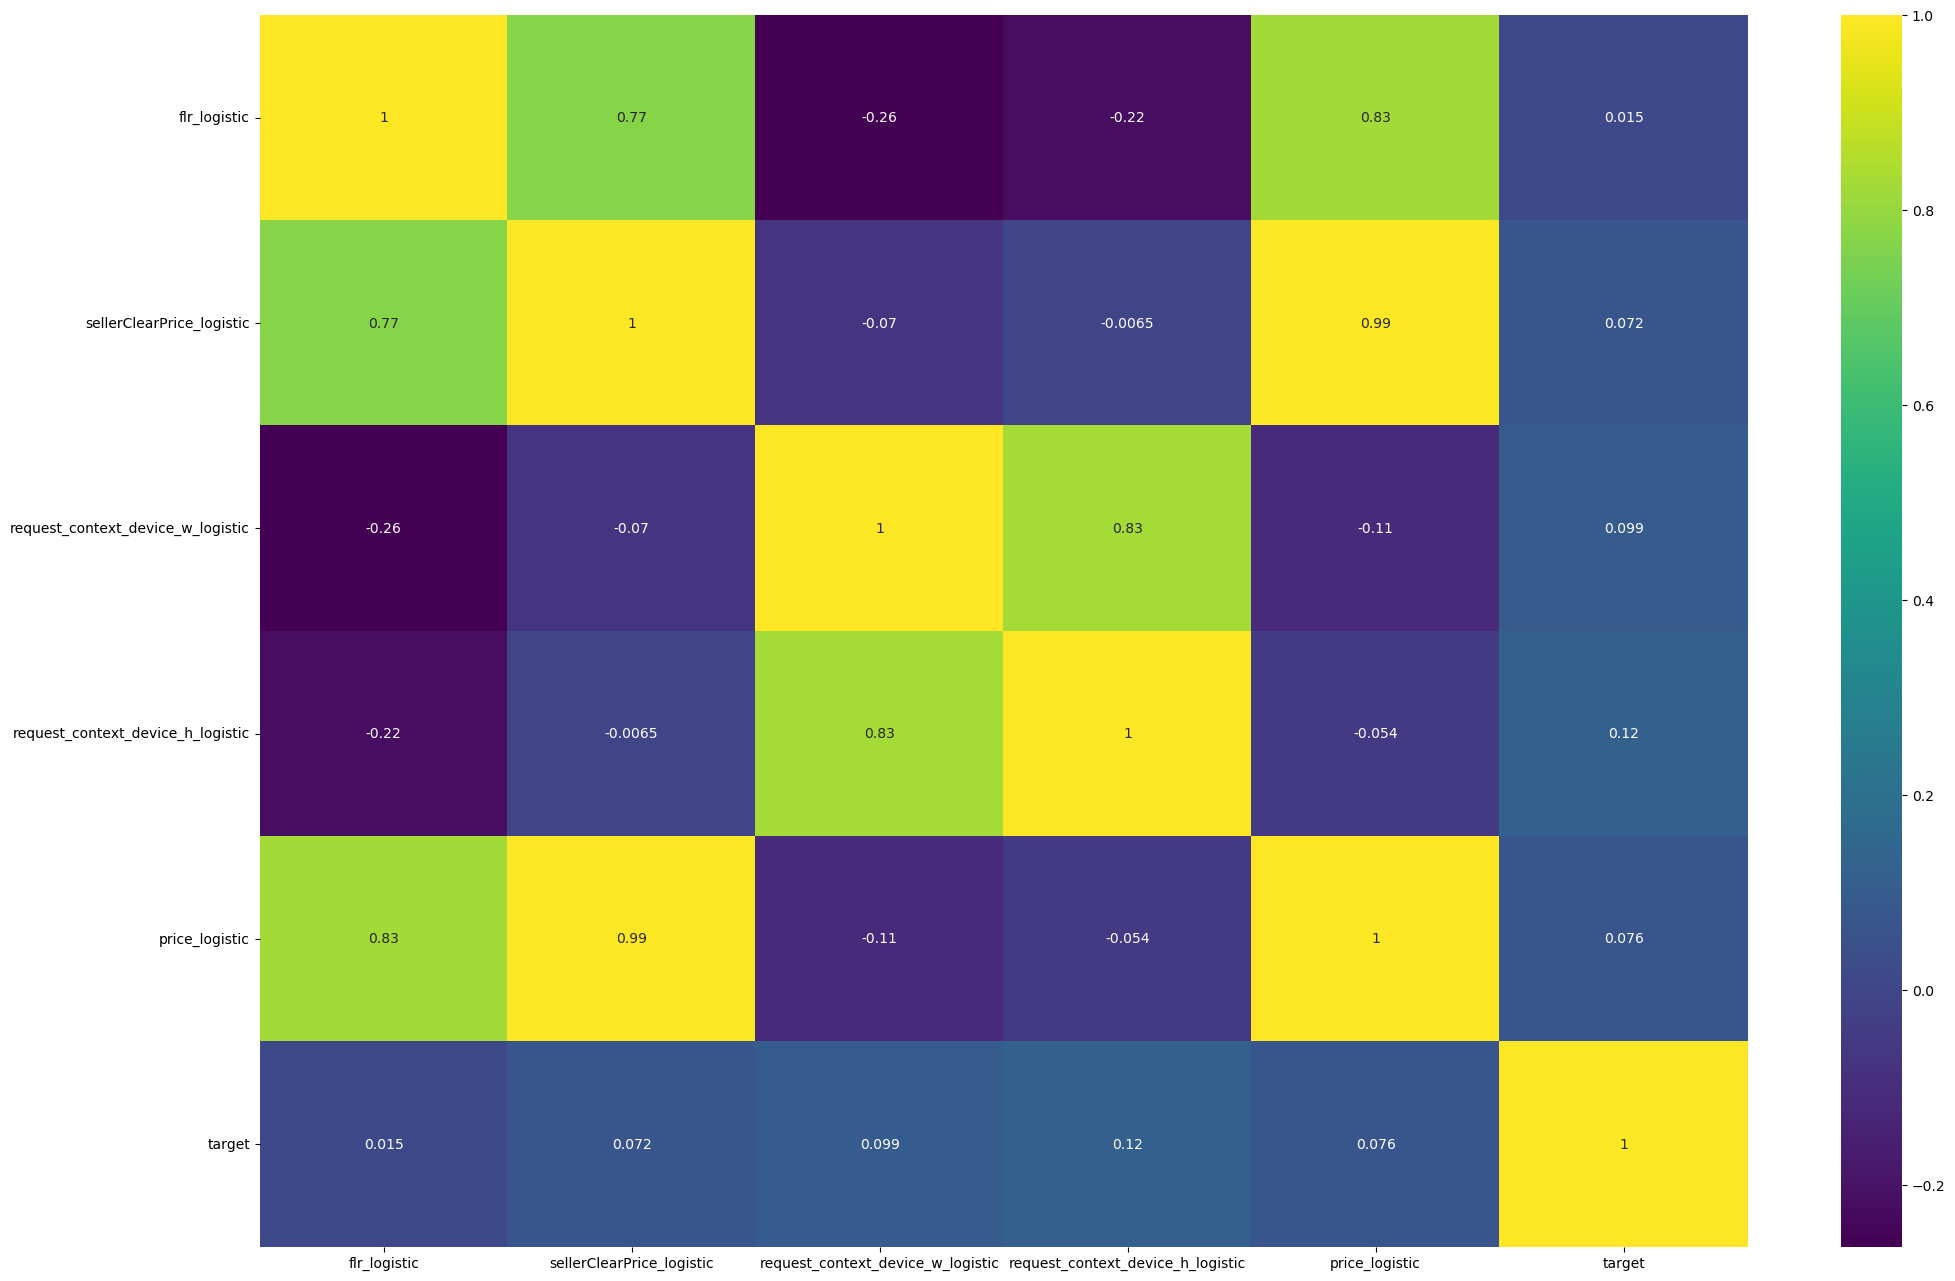

In [59]:
plt.figure(figsize=(24, 16))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

#### features <price_logistic (gini = 12.26)> and <sellerClearPrice_logistic> are highly correlated

_logistic is deleted (gini 11.96)

****

****

# Outliers Detection and Removing

In [60]:
## We need to remove outliers found in the analysis

# 🔄 Data PreProcessing

**Section Goals:** 
> - Remove or fill any missing data. 
> - Remove unnecessary or repetitive features. 
> - Convert categorical string features to dummy variables.

In [61]:
# The length of the data
print(f"The Length of the data: {data.shape}")

The Length of the data: (500000, 14)


In [62]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

### NA detection

In [63]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

In [64]:
#data.dropna(inplace=True)

In [65]:
data.shape

(500000, 14)

## 🧮 Categorical Variables and Dummy Variables

In [66]:
print([column for column in data.columns if data[column].dtype == object])

['dsp_grouped_woe', 'auctionBidFloorSource_woe', 'sdkver_grouped_woe', 'bundle_woe', 'os_woe', 'bidderFlrPolicy_woe', 'contype_woe', 'request_context_device_type_woe']


In [67]:
#dummies = ['']
#data = pd.get_dummies(data, columns=dummies, drop_first=True)

## 🔪 Train Test Split

In [68]:
w_p = data[target_feature].value_counts()[0] / data.shape[0]
w_n = data[target_feature].value_counts()[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.971652
Weight of negative values 0.028348


In [69]:
features_selected

['flr_logistic',
 'sellerClearPrice_logistic',
 'request_context_device_w_logistic',
 'request_context_device_h_logistic',
 'price_logistic',
 'dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',
 'bidderFlrPolicy_woe',
 'contype_woe',
 'request_context_device_type_woe']

In [70]:
features_selected_and_target = features_selected + [target_feature]

train = data
test = data_test
#train, test = train_test_split(data[features_selected_and_target], test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(500000, 14)
(1500000, 14)


## 📏 Normalizing the data

In [71]:
X_train, y_train = train.drop(target_feature, axis=1), train[target_feature]
X_test, y_test = test.drop(target_feature, axis=1), test[target_feature]

# 🤖 Models Building

In [72]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


#  ✔️ 1. Artificial Neural Networks (ANNs)

In [64]:

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [65]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [10, 10, 5]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model_ann = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model_ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5, #epochs=20,
    batch_size=32
)

Epoch 1/5
15625/15625 [==============================] - 95s 6ms/step - loss: 0.1141 - AUC: 0.8238 - val_loss: 0.2896 - val_AUC: 0.8533
Epoch 2/5
15625/15625 [==============================] - 97s 6ms/step - loss: 0.0984 - AUC: 0.8606 - val_loss: 0.2741 - val_AUC: 0.8552
Epoch 3/5
15610/15625 [============================>.] - ETA: 0s - loss: 0.0963 - AUC: 0.8679

In [ ]:
factor_utils.plot_learning_evolution(r)

In [ ]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_ann = model_ann.predict(X_train)
f1_ann, cutoff_ann, y_pred_train_ann = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_ann, verbose = True, text = "train")
y_test_proba_pred_ann = model_ann.predict(X_test)
f1_ann_test, _ , y_pred_test_ann= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_ann, cutoff_ann, verbose = True, text = "test")

In [ ]:
factor_utils.print_score(y_test, y_pred_test_ann.round(), train=False)

In [138]:
scores_Gini_dict = {
    'ANNs': {
        'Train': 2 * roc_auc_score(y_train, y_train_proba_pred_ann) - 1,
        'Test': 2 * roc_auc_score(y_test, y_test_proba_pred_ann) - 1,
    },
}

scores_F1_dict = {
    'ANNs': {
        'Train': f1_ann,
        'Test': f1_ann_test,
    },
}

In [ ]:
scores_Gini_dict

In [ ]:
scores_F1_dict

# ✔️ 2. XGBoost Classifier

In [ ]:
param_grid = dict(
    n_estimators=stats.randint(10, 500),
    max_depth=stats.randint(1, 10),
    learning_rate=stats.uniform(0, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=60, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_
#best_params['tree_method'] = 'gpu_hist'
# best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
print(f"Best Parameters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)



In [ ]:
y_train_proba_pred_xgb = xgb_clf.predict_proba(X_train)[:, 1]
f1_train_xgb, cutoff_xgb, y_pred_train_xgb = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_xgb, verbose = True, text = "train")
y_test_proba_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
f1_test_xgb, _ , y_pred_test_xgb= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_xgb, cutoff_xgb, verbose = True, text = "test")

In [ ]:
factor_utils.print_score(y_train, y_pred_train_xgb, train = True)
factor_utils.print_score(y_test, y_pred_test_xgb, train=False)

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Nondefault', 'Default']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [ ]:
scores_Gini_dict['XGBoost'] = {
        'Train': 2 * roc_auc_score(y_train, xgb_clf.predict(X_train)) - 1,
        'Test': 2 * roc_auc_score(y_test, xgb_clf.predict(X_test)) - 1,
    }

scores_F1_dict['XGBoost'] = {    
        'Train': f1_train_xgb,
        'Test': f1_test_xgb,     
}


In [ ]:
scores_Gini_dict


In [ ]:

scores_F1_dict

# ✔️ 3. Random Forest Classifier

In [ ]:
param_grid = dict(
     n_estimators=stats.randint(100, 1500),
     max_depth=stats.randint(10, 100),  #max_depth (максимальная глубина деревьев).
     min_samples_split=stats.randint(1, 10), #min_samples_split (минимальное количество примеров для разбиения узла).
     min_samples_leaf=stats.randint(1, 10), #min_samples_leaf (минимальное количество примеров в листе).
     #max_features (ограничить число признаков для разбиения).
)

rf_clf = RandomForestClassifier(n_estimators=10)
rf_cv = RandomizedSearchCV(
     rf_clf, param_grid, cv=3, n_iter=60, 
     scoring='roc_auc', n_jobs=-1, verbose=1
 )
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)



In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'NonDefault'])

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)

In [ ]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_rf = rf_clf.predict_proba(X_train)[:, 1]
f1_train_rf, cutoff_rf, y_pred_train_rf = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_rf, verbose = True, text = "train")
y_test_proba_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
f1_test_rf, _ , y_pred_test_rf= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_rf, cutoff_rf, verbose = True, text = "test")

In [ ]:
factor_utils.print_score(y_train, y_pred_train_rf, train=True)
factor_utils.print_score(y_test, y_pred_test_rf, train=False)

In [145]:
scores_Gini_dict['Random Forest'] = {
        'Train': 2 * roc_auc_score(y_train, y_train_proba_pred_rf) - 1,
        'Test': 2 * roc_auc_score(y_test, y_test_proba_pred_rf) -,
    }

scores_F1_dict['Random Forest'] = {    
        'Train': f1_train_rf,
        'Test': f1_test_rf,     
}

In [ ]:
scores_Gini_dict


In [ ]:

scores_F1_dict

# ✔️ 4. Logistic regression

In [ ]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
logreg.fit(X_train, y_train)

In [ ]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_logreg = logreg.predict_proba(X_train)[:, 1]
f1_train_logreg, cutoff_logreg, y_pred_train_logreg = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_logreg, verbose = True, text = "train")
y_test_proba_pred_logreg = logreg.predict_proba(X_test)[:, 1]
f1_test_logreg, _ , y_pred_test_logreg= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_logreg, cutoff_logreg, verbose = True, text = "test")

In [ ]:
factor_utils.print_score(y_train, y_pred_train_logreg, train=True)
factor_utils.print_score(y_test, y_pred_test_logreg, train=False)

In [ ]:
scores_Gini_dict['Logistic regression'] = {
        'Train': 2 * roc_auc_score(y_train, y_train_proba_pred_logreg) - 1,
        'Test': 2 * roc_auc_score(y_test, y_test_proba_pred_logreg) - 1,
    }
scores_Gini_dict

In [ ]:
scores_F1_dict['Logistic regression'] = {    
        'Train': f1_train_logreg,
        'Test': f1_test_logreg,     
}
scores_F1_dict

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    logreg, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Nondefault', 'Default']
)

disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, ax=disp.ax_)


# 📊 Comparing Models Prerformance

In [ ]:
ml_models = {
    'Random Forest': rf_clf, 
    'XGBoost': xgb_clf, 
    'ANNs': model_ann,
    'Logreg': logreg,
}

for model2 in ml_models:
    print(f"{model2.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model2].predict(X_test)):.3f}")

In [ ]:
scores_Gini_dict

In [ ]:
scores_F1_df = pd.DataFrame(scores_F1_dict)
scores_F1_df.hvplot.barh(
    width=500, height=400, 
    title="F1 of ML Models", xlabel="F1 Scores", 
    alpha=0.4, legend='top'
)

In [ ]:
scores_Gini_dict

In [ ]:
scores_df = pd.DataFrame(scores_Gini_dict)
scores_df.hvplot.barh(
    width=500, height=400, 
    title="ROC Scores of ML Models", xlabel="ROC Scores", 
    alpha=0.4, legend='top'
)